## Robert Feliciano and Pranav Yalamala
## CS 584 Final Project

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict, OrderedDict
import stanza
import pickle

### Data Preprocessing

In [2]:
VAERS_IDs = set()

# Read in the data
VAERS_VAX = pd.read_csv('AllVAERSDataCSVS/2020VAERSVAX.csv', encoding='latin-1')

#filters out the VAERS_IDs that are not COVID19
for index, row in VAERS_VAX.iterrows():
    if row['VAX_TYPE'] == 'COVID19':
        # print(row['VAERS_ID'])
        VAERS_IDs.add(row['VAERS_ID'])


In [3]:
# Read in the data for VAERS_DATA and VAERS_SYMPTOMS
VAERS_DATA = pd.read_csv('AllVAERSDataCSVS/2020VAERSDATA.csv', encoding='latin-1')
VAERS_SYMPTOMS = pd.read_csv('AllVAERSDataCSVS/2020VAERSSYMPTOMS.csv', encoding='latin-1')

#Filters out the VAERS_IDs that are not COVID19
FILTERED_DATA = VAERS_DATA[VAERS_DATA['VAERS_ID'].isin(VAERS_IDs)]
#Filters out the VAERS_IDs that are not COVID19
FILTERED_SYMPTOMS = VAERS_SYMPTOMS[VAERS_SYMPTOMS['VAERS_ID'].isin(VAERS_IDs)]

C:\Users\pyala\AppData\Local\Temp\ipykernel_8452\3166492616.py:2: DtypeWarning: Columns (7,9,10,12,15,16,23,31) have mixed types. Specify dtype option on import or set low_memory=False.
  VAERS_DATA = pd.read_csv('AllVAERSDataCSVS/2020VAERSDATA.csv', encoding='latin-1')


In [6]:
grouped_data = FILTERED_SYMPTOMS.groupby('VAERS_ID').agg(lambda x: x.dropna().tolist())

def flatten_symptoms(series):
    series = [x if isinstance(x,list) else [x] for x in series]
    flat_list = [item for sublist in series for item in sublist]
    return flat_list

grouped_data_flat = grouped_data.applymap(flatten_symptoms)

def combine_symptoms(row):
    symptoms = []
    versions = []

    for i in range(1,6):
        symptom_col = f'SYMPTOM{i}'
        version_col = f'SYMPTOMVERSION{i}'

        symptoms += [sym for sym in row[symptom_col] if pd.notnull(sym)]
        versions += [ver for ver in row[version_col] if pd.notnull(ver)]
    return pd.Series([symptoms, versions], index=['SYMPTOMS', 'VERSIONS'])

combined_data = grouped_data_flat.reset_index().apply(combine_symptoms, axis=1)
FILTERED_SYMPTOMS_FIXED = pd.concat([grouped_data_flat.reset_index()['VAERS_ID'], combined_data], axis=1)

FILTERED_SYMPTOMS_FIXED


,VAERS_ID,SYMPTOMS,VERSIONS
0,902418,"[Hypoaesthesia, Injection site hypoaesthesia]","[24.0, 24.0]"
1,902440,[Headache],[23.1]
2,902446,"[Erythema, Feeling hot, Flushing]","[23.1, 23.1, 23.1]"
3,902464,"[Dizziness, Electrocardiogram normal, Hyperhid...","[23.1, 23.1, 23.1, 23.1, 23.1]"
4,902465,"[Dysgeusia, Sensory disturbance, Oral pruritus...","[23.1, 23.1, 23.1, 23.1, 23.1, 23.1, 23.1]"
...,...,...,...
10376,918440,"[Dysgeusia, Myalgia, Pain, Painful respiration]","[23.1, 23.1, 23.1, 23.1]"
10377,918441,"[Injection site pain, Injection site swelling,...","[23.1, 23.1, 23.1]"
10378,918442,"[Arthralgia, Dysgeusia, Injection site pain, I...","[23.1, 23.1, 23.1, 23.1, 23.1]"
10379,918503,"[Chest discomfort, Nausea]","[23.1, 23.1]"


In [6]:
FILTERED_SYMPTOMS

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
44686,902418,Hypoaesthesia,24.0,Injection site hypoaesthesia,24.0,NaN,NaN,NaN,NaN,NaN,NaN
44701,902440,Headache,23.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44707,902446,Erythema,23.1,Feeling hot,23.1,Flushing,23.1,NaN,NaN,NaN,NaN
44726,902464,Dizziness,23.1,Electrocardiogram normal,23.1,Hyperhidrosis,23.1,Laboratory test normal,23.1,Presyncope,23.1
44727,902465,Dysgeusia,23.1,Oral pruritus,23.1,Paraesthesia,23.1,Paraesthesia oral,23.1,Parosmia,23.1
...,...,...,...,...,...,...,...,...,...,...,...
60776,918440,Dysgeusia,23.1,Myalgia,23.1,Pain,23.1,Painful respiration,23.1,NaN,NaN
60777,918441,Injection site pain,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN,NaN,NaN
60778,918442,Arthralgia,23.1,Dysgeusia,23.1,Injection site pain,23.1,Injection site swelling,23.1,Paraesthesia,23.1
60779,918503,Chest discomfort,23.1,Nausea,23.1,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
FILTERED_DATA

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
36876,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,NaN,...,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,none
36890,902440,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,NaN,...,NaN,NaN,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NaN
36896,902446,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",NaN,...,none,"Hypertension, sleep apnea, hypothyroidism",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,"Contrast Dye IV contrast, shellfish, strawberry"
36913,902464,12/15/2020,LA,42.0,42.0,NaN,M,NaN,within 15 minutes progressive light-headedness...,NaN,...,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,Y,none
36914,902465,12/15/2020,AR,60.0,60.0,NaN,F,NaN,Pt felt wave come over body @ 1218 starting in...,NaN,...,"Bronchitis, finished prednisone on 12-13-20","hypertension, fibromyalgia",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,Biaxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49628,918440,12/31/2020,AR,NaN,NaN,NaN,F,NaN,muscle aches & pain metal taste in mouth lungs...,NaN,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
49629,918441,12/31/2020,NE,35.0,35.0,NaN,F,NaN,"Injection site is hot, tender to touch, swollen",NaN,...,NaN,NaN,NaN,NaN,2,12/31/2020,NaN,NaN,NaN,NaN
49630,918442,12/31/2020,AR,NaN,34.0,NaN,F,NaN,Injection site - swollen arm Muscle aches Joi...,NaN,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
49631,918503,12/31/2020,RI,50.0,50.0,NaN,F,NaN,"Nausea, tightness in chest from nausea BP 10...",NaN,...,NaN,Asthma,NaN,NaN,2,12/30/2020,NaN,NaN,NaN,"PCN, Prednisone, Bleach"


In [8]:
len(VAERS_IDs)

10381

In [9]:
symptoms = set()
symptom_dict = defaultdict(int)

#create a set of all the symptoms realted to covid19 vaccines
for index, row in FILTERED_SYMPTOMS.iterrows():
    if str(row['SYMPTOM1']) != 'nan':
        symptom_dict[row['SYMPTOM1']] += 1

        if str(row['SYMPTOM2']) != 'nan':
            symptom_dict[row['SYMPTOM2']] += 1

            if str(row['SYMPTOM3']) != 'nan':
                symptom_dict[row['SYMPTOM3']] += 1

                if str(row['SYMPTOM4']) != 'nan':
                    symptom_dict[row['SYMPTOM4']] += 1

                    if str(row['SYMPTOM5']) != 'nan':
                        symptom_dict[row['SYMPTOM5']] += 1


In [10]:
#sorts the symptoms into the top 100 most common symptoms
sorted_symptoms = sorted(symptom_dict.items(), key=lambda x: x[1], reverse=True)[:100]
sorted_symptoms = dict(sorted_symptoms)
sorted_symptoms

{'Headache': 2511,
 'Fatigue': 1775,
 'Chills': 1701,
 'Dizziness': 1629,
 'Pain': 1598,
 'Pyrexia': 1596,
 'Nausea': 1555,
 'Injection site pain': 1211,
 'Pain in extremity': 952,
 'Myalgia': 792,
 'Paraesthesia': 713,
 'Pruritus': 671,
 'Arthralgia': 603,
 'Dyspnoea': 587,
 'Rash': 584,
 'Flushing': 524,
 'Hypoaesthesia': 474,
 'Vomiting': 452,
 'Urticaria': 441,
 'Palpitations': 433,
 'Injection site erythema': 416,
 'Cough': 400,
 'Tachycardia': 385,
 'Diarrhoea': 383,
 'Malaise': 383,
 'Hyperhidrosis': 379,
 'Paraesthesia oral': 363,
 'Heart rate increased': 360,
 'Injection site swelling': 358,
 'Erythema': 352,
 'Feeling hot': 343,
 'Chest discomfort': 340,
 'Feeling abnormal': 327,
 'Asthenia': 323,
 'Throat irritation': 285,
 'Oropharyngeal pain': 258,
 'SARS-CoV-2 test negative': 258,
 'Blood pressure increased': 252,
 'Tremor': 242,
 'Throat tightness': 241,
 'Lymphadenopathy': 240,
 'Hypoaesthesia oral': 214,
 'Injection site warmth': 207,
 'Body temperature increased': 197

In [7]:
symptom_dist_fixed = defaultdict(int)
for _, row in FILTERED_SYMPTOMS_FIXED.iterrows():
    n_symptons = len(row['SYMPTOMS'])
    symptom_dist_fixed[n_symptons] += 1

OrderedDict([(1, 1541), (2, 1867), (3, 1874), (4, 1457), (5, 1175), (6, 805), (7, 540), (8, 366), (9, 228), (10, 166), (11, 83), (12, 63), (13, 53), (14, 35), (15, 34), (16, 20), (17, 19), (18, 16), (19, 6), (20, 5), (21, 2), (22, 3), (23, 5), (24, 1), (25, 2), (27, 1), (28, 1), (29, 1), (35, 1), (39, 3), (40, 1), (41, 1), (43, 1), (53, 3), (67, 1), (69, 1)])


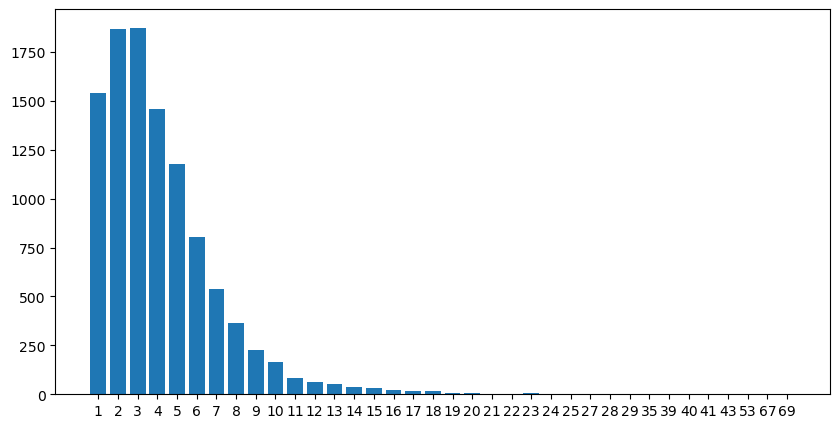

In [15]:
symptom_dist_fixed = OrderedDict(sorted(symptom_dist_fixed.items()))
print(symptom_dist_fixed)
names = list(symptom_dist_fixed.keys())
values = list(symptom_dist_fixed.values())

plt.figure(figsize=(10, 5))
plt.bar(range(len(symptom_dist_fixed)), values, tick_label=names)
plt.show()

Clearly there are many more reports with 5 symptoms than other numbers of symptoms

### Extracting Symptom-related Entities

In [13]:
stanza.download(lang='en', package='mimic', processors={'ner': 'i2b2'})
nlp = stanza.Pipeline(lang='en', package='mimic', processors={'ner': 'i2b2'})

2023-11-05 13:00:52 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| forward_charlm  | mimic          |
| backward_charlm | mimic          |
| pretrain        | mimic          |

2023-11-05 13:00:52 INFO: File exists: /home/robert/stanza_resources/en/tokenize/mimic.pt
2023-11-05 13:00:52 INFO: File exists: /home/robert/stanza_resources/en/pos/mimic_charlm.pt
2023-11-05 13:00:52 INFO: File exists: /home/robert/stanza_resources/en/lemma/mimic_nocharlm.pt
2023-11-05 13:00:52 INFO: File exists: /home/robert/stanza_resources/en/depparse/mimic_charlm.pt
2023-11-05 13:00:52 INFO: File exists: /home/robert/stanza_resources/en/ner/i2b2.pt
2023-11-05 13:00:52 INFO: File exists: /home/robert/stanza_resources/en/forw

2023-11-05 13:00:53 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | mimic          |
| pos       | mimic_charlm   |
| lemma     | mimic_nocharlm |
| depparse  | mimic_charlm   |
| ner       | i2b2           |

2023-11-05 13:00:54 INFO: Using device: cuda
2023-11-05 13:00:54 INFO: Loading: tokenize
2023-11-05 13:00:56 INFO: Loading: pos
2023-11-05 13:00:56 INFO: Loading: lemma
2023-11-05 13:00:56 INFO: Loading: depparse
2023-11-05 13:00:56 INFO: Loading: ner
2023-11-05 13:00:57 INFO: Done loading processors!


In [19]:
def get_symptoms(text):
    stanza_doc = nlp(text)
    symptoms = []
    for ent in stanza_doc.entities:
        if ent.type == 'PROBLEM':
            symptoms.append(ent.text)
    return symptoms

In [21]:
# FILTERED_DATA_small = FILTERED_DATA[:5]
FILTERED_DATA['SYMPTOMS'] = FILTERED_DATA['SYMPTOM_TEXT'].astype(str).apply(get_symptoms)

FILTERED_DATA

/tmp/ipykernel_2052/1909308140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FILTERED_DATA['SYMPTOMS'] = FILTERED_DATA['SYMPTOM_TEXT'].astype(str).apply(get_symptoms)


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,SYMPTOMS
36876,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,NaN,...,none,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,none,"[mild numbness, injection site]"
36890,902440,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,NaN,...,NaN,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NaN,[Headache]
36896,902446,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",NaN,...,"Hypertension, sleep apnea, hypothyroidism",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,"Contrast Dye IV contrast, shellfish, strawberry",[warm]
36913,902464,12/15/2020,LA,42.0,42.0,NaN,M,NaN,within 15 minutes progressive light-headedness...,NaN,...,none,NaN,NaN,2,12/15/2020,NaN,NaN,Y,none,"[progressive light-headedness, near-syncope, d..."
36914,902465,12/15/2020,AR,60.0,60.0,NaN,F,NaN,Pt felt wave come over body @ 1218 starting in...,NaN,...,"hypertension, fibromyalgia",NaN,NaN,2,12/15/2020,NaN,NaN,NaN,Biaxin,"[Bad taste in mouth, tingling in body , legs,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49628,918440,12/31/2020,AR,NaN,NaN,NaN,F,NaN,muscle aches & pain metal taste in mouth lungs...,NaN,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,"[muscle aches, pain metal taste, Deep Breath]"
49629,918441,12/31/2020,NE,35.0,35.0,NaN,F,NaN,"Injection site is hot, tender to touch, swollen",NaN,...,NaN,NaN,NaN,2,12/31/2020,NaN,NaN,NaN,NaN,"[Injection site, tender, swollen]"
49630,918442,12/31/2020,AR,NaN,34.0,NaN,F,NaN,Injection site - swollen arm Muscle aches Joi...,NaN,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,"[Injection site, swollen arm, Muscle aches, Jo..."
49631,918503,12/31/2020,RI,50.0,50.0,NaN,F,NaN,"Nausea, tightness in chest from nausea BP 10...",NaN,...,Asthma,NaN,NaN,2,12/30/2020,NaN,NaN,NaN,"PCN, Prednisone, Bleach","[Nausea, tightness in chest, nausea, nausea]"


In [22]:
print(FILTERED_DATA[:1]['SYMPTOMS'])

36876    [mild numbness, injection site]
Name: SYMPTOMS, dtype: object


In [25]:
SYMPTOM_DF = FILTERED_DATA[['VAERS_ID', 'SYMPTOM_TEXT', 'HISTORY', 'SYMPTOMS']]
SYMPTOM_DF

,VAERS_ID,SYMPTOM_TEXT,HISTORY,SYMPTOMS
36876,902418,Patient experienced mild numbness traveling fr...,none,"[mild numbness, injection site]"
36890,902440,C/O Headache,NaN,[Headache]
36896,902446,"felt warm, hot and face and ears were red and ...","Hypertension, sleep apnea, hypothyroidism",[warm]
36913,902464,within 15 minutes progressive light-headedness...,none,"[progressive light-headedness, near-syncope, d..."
36914,902465,Pt felt wave come over body @ 1218 starting in...,"hypertension, fibromyalgia","[Bad taste in mouth, tingling in body , legs,..."
...,...,...,...,...
49628,918440,muscle aches & pain metal taste in mouth lungs...,NaN,"[muscle aches, pain metal taste, Deep Breath]"
49629,918441,"Injection site is hot, tender to touch, swollen",NaN,"[Injection site, tender, swollen]"
49630,918442,Injection site - swollen arm Muscle aches Joi...,NaN,"[Injection site, swollen arm, Muscle aches, Jo..."
49631,918503,"Nausea, tightness in chest from nausea BP 10...",Asthma,"[Nausea, tightness in chest, nausea, nausea]"


In [45]:
SYMPTOM_DF.to_csv('extracted_symptoms.csv', index=False)

In [46]:
FILTERED_SYMPTOMS.to_csv('filtered_symtpoms.csv', index=False)

We are going to save the standard symptoms and top 100 symtpoms lists in a pickle file for future use.

In [6]:
class SymptomsContainer:
    def __init__(self, top100, standard):
        self.top100 = top100
        self.standard = standard

In [ ]:
symptoms_container = SymptomsContainer(sorted_symptoms, list(symptom_dict.keys()))

with open('symptoms_container.pkl', 'wb') as pkl:
    pickle.dump(symptoms_container, pkl)

Now just want to test that it saved correctly

In [10]:
with open('symptoms_container.pkl', 'rb') as file:
    loaded = pickle.load(file)

top100 = loaded.top100
std_symptoms = loaded.standard

In [15]:
top100

{'Headache': 2511,
 'Fatigue': 1775,
 'Chills': 1701,
 'Dizziness': 1629,
 'Pain': 1598,
 'Pyrexia': 1596,
 'Nausea': 1555,
 'Injection site pain': 1211,
 'Pain in extremity': 952,
 'Myalgia': 792,
 'Paraesthesia': 713,
 'Pruritus': 671,
 'Arthralgia': 603,
 'Dyspnoea': 587,
 'Rash': 584,
 'Flushing': 524,
 'Hypoaesthesia': 474,
 'Vomiting': 452,
 'Urticaria': 441,
 'Palpitations': 433,
 'Injection site erythema': 416,
 'Cough': 400,
 'Tachycardia': 385,
 'Diarrhoea': 383,
 'Malaise': 383,
 'Hyperhidrosis': 379,
 'Paraesthesia oral': 363,
 'Heart rate increased': 360,
 'Injection site swelling': 358,
 'Erythema': 352,
 'Feeling hot': 343,
 'Chest discomfort': 340,
 'Feeling abnormal': 327,
 'Asthenia': 323,
 'Throat irritation': 285,
 'Oropharyngeal pain': 258,
 'SARS-CoV-2 test negative': 258,
 'Blood pressure increased': 252,
 'Tremor': 242,
 'Throat tightness': 241,
 'Lymphadenopathy': 240,
 'Hypoaesthesia oral': 214,
 'Injection site warmth': 207,
 'Body temperature increased': 197